<a href="https://colab.research.google.com/github/vagarciar/TAM-2025-2/blob/main/25_parcial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diego Luis Salazar Perlaza

Daniel Mauricio Mejía Hoyos

Luis Fernando Castro Buchelly

Julian David Morales Pineda

Valeria García Rodas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

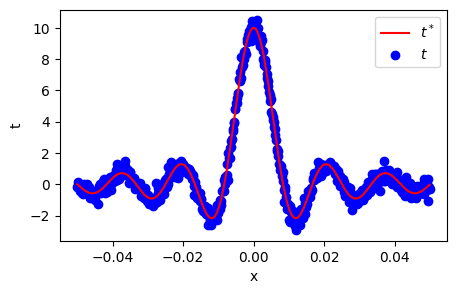

In [ ]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(-3*To,3*To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 20 #ruido según SNR dB
#señal limpia - objetivo
argumento = 2*np.pi*Fo*X
# Manejo de la división por cero en el punto X=0
tt = np.zeros_like(argumento)
non_zero_indices = argumento != 0
tt[non_zero_indices] = A * np.sin(argumento[non_zero_indices]) / argumento[non_zero_indices]
#modelo con función sinoidal contaminada con ruido Gaussiano
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

potencia_ruido = var_snr(tt, snrdB)
ruido_gaussiano = np.sqrt(potencia_ruido) * np.random.randn(len(X))
t = tt + ruido_gaussiano

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)
tt = tt.reshape(-1,1)


plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='$t^*$')
plt.scatter(X,t,c='b',label='$t$')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
# --- Split 70% train / 30% test ---
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, shuffle=True, random_state=42)


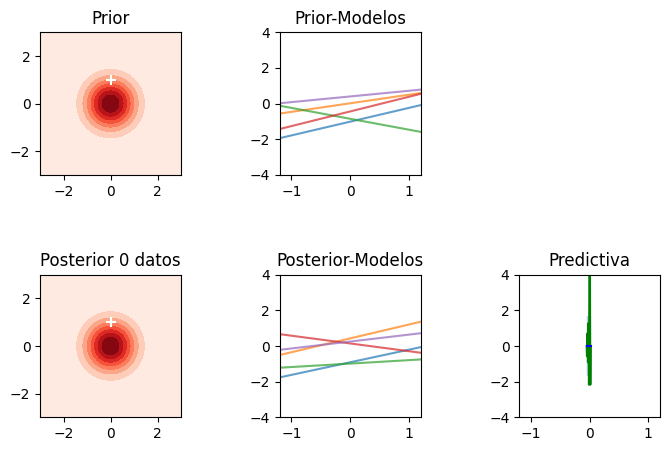

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# ---------- Señal simulada ----------
Fo = 60
A = 10
To = 1/Fo
Fs = 100*Fo
X = np.arange(-3*To, To, 1/Fs)

snrdB = 10
def var_snr(signal, snrdB):
    Ps = np.mean(signal**2)
    Pn = Ps / (10**(snrdB/10))
    return Pn

tt = A*np.sin(2*np.pi*Fo*X)/(2*np.pi*Fo*X)
t = (A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X)))/(2*np.pi*Fo*X)

X = X.reshape(-1,1)
t = t.reshape(-1,1)

# ---------- Funciones auxiliares ----------
def my_2Dpdf(mu, Sigma, axes, cmap, xlim, ylim, n=100):
    """Dibuja la pdf 2D gaussiana en el espacio de pesos."""
    from scipy.stats import multivariate_normal
    x = np.linspace(xlim[0], xlim[1], n)
    y = np.linspace(ylim[0], ylim[1], n)
    Xg, Yg = np.meshgrid(x, y)
    pos = np.dstack((Xg, Yg))
    rv = multivariate_normal(mu, Sigma)
    Z = rv.pdf(pos)
    axes.contourf(Xg, Yg, Z, cmap=cmap)

def my_linregsyn(mu, Sigma, axes, xlim, ylim, n_samples=5):
    """Muestra regresores lineales muestreados de la distribución de pesos."""
    ws = np.random.multivariate_normal(mu, Sigma, n_samples)
    xgrid = np.linspace(xlim[0], xlim[1], 50)
    for w in ws:
        ygrid = w[0] + w[1]*xgrid
        axes.plot(xgrid, ygrid, alpha=0.7)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

def my_posterior_update(Xn, tn, sig_eta, sig_w, tol=1e-10):
    """Actualiza posterior bayesiano para regresión lineal."""
    N, D = Xn.shape
    # Agregar bias
    Phi = np.hstack([np.ones((N,1)), Xn])
    S0 = sig_w * np.eye(D+1)
    SN_inv = np.linalg.inv(S0) + (1/sig_eta)*Phi.T @ Phi
    SN = np.linalg.inv(SN_inv + tol*np.eye(D+1))
    mN = (1/sig_eta) * SN @ Phi.T @ tn
    return mN.ravel(), SN

def my_predictiva_update(Xgrid, mN, SN, sig_eta):
    """Distribución predictiva: media y varianza para cada x."""
    Phi = np.hstack([np.ones((Xgrid.shape[0],1)), Xgrid])
    mean = Phi @ mN.reshape(-1,1)
    var = np.sum(Phi @ SN * Phi, axis=1).reshape(-1,1) + sig_eta
    return mean, np.sqrt(var)

# ---------- Parámetros iniciales ----------
ind = np.random.randint(0, X.shape[0], size=X.shape[0])
mu_w = np.array([0.0,0.0])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

sig_eta = 0.2  # varianza del ruido

# "verdaderos" pesos para referencia (lineal ficticia)
w_ = np.array([0.0, 1.0])

wxlim = [-3,3]
wylim = [-3,3]
xlim = [-1.2,1.2]
ylim = [-4,4]

# ---------- Animación ----------
fig, ax = plt.subplots(2, 3,figsize=(8,5))
ax[0,2].axis('off')

def update(i):
    ax[0,0].clear(); ax[0,1].clear()
    ax[1,0].clear(); ax[1,1].clear(); ax[1,2].clear()

    # Prior
    my_2Dpdf(mu_w, S_w, axes=ax[0,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0,1], xlim=xlim, ylim=ylim)

    # Posterior con i datos
    mN,SN = my_posterior_update(X[ind[:i]], t[ind[:i]], sig_eta, sig_w)
    my_2Dpdf(mN, SN, axes=ax[1,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1,1], xlim=xlim, ylim=ylim)
    ax[1,1].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')

    # Pesos reales (referencia)
    ax[1,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')
    ax[0,0].scatter(w_[0],w_[1],marker='+',s=60,c='w')

    # Predictiva
    mnew,snew = my_predictiva_update(X, mN, SN, sig_eta)
    ax[1,2].plot(X[:,0], tt, c='g', label="Señal limpia")
    ax[1,2].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')
    ax[1,2].plot(X[:,0], mnew, c='b', label="Media predictiva")
    ii = np.argsort(X[:,0])
    ax[1,2].fill_between(X[ii,0].ravel(),
                         (mnew[ii] - 2*snew[ii]).ravel(),
                         (mnew[ii] + 2*snew[ii]).ravel(),
                         alpha=0.3)
    ax[1,2].set_xlim(xlim); ax[1,2].set_ylim(ylim)

    # Títulos
    ax[0,0].set_title('Prior')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title(f'Posterior {i} datos')
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7,hspace=0.7)

anim = animation.FuncAnimation(fig, update,
                               frames=np.array([0,1,2,3,5,7,9,10,15,20,25,50,100,250,500]),
                               blit=False)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())


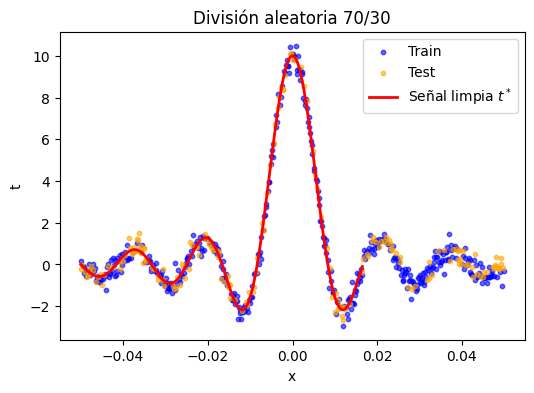

In [ ]:
# --- Visualización ---
plt.figure(figsize=(6,4))
plt.scatter(X_train, t_train, c="blue", s=10, alpha=0.6, label="Train")
plt.scatter(X_test, t_test, c="orange", s=10, alpha=0.6, label="Test")
plt.plot(X, tt, 'r', linewidth=2, label="Señal limpia $t^*$")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.title("División aleatoria 70/30")
plt.show()


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.98689e-50): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


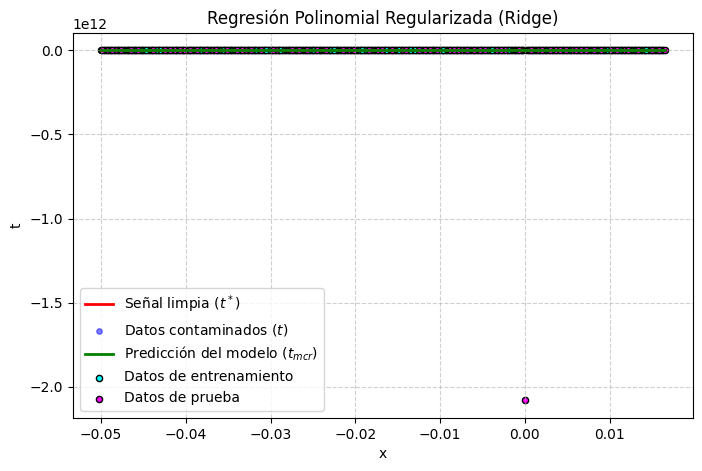

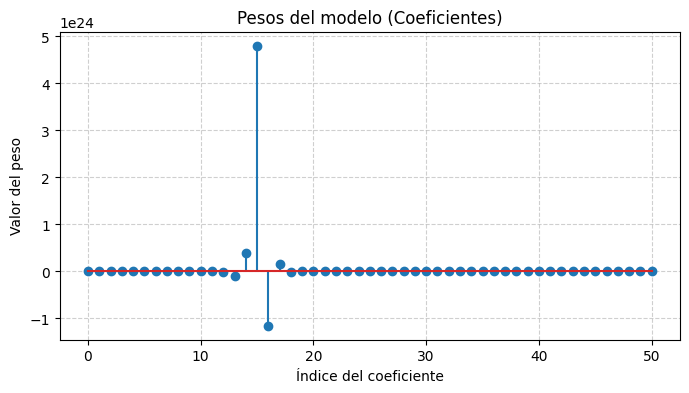

In [ ]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# Generación de la representación polinomial
Q = 50
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)

# Particionar datos con 70% train y 30% test
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)

# Obtener los índices para el entrenamiento y la prueba
train_i, test_i = next(rs.split(X))

# Regresor
lambdaR = 1e-50
reg_mc = Ridge(alpha=lambdaR)

# Entrenar el modelo con los datos de entrenamiento
reg_mc.fit(Phi[train_i], t[train_i])

# Realizar predicciones sobre TODO el conjunto de datos para la gráfica
t_mc_pred = reg_mc.predict(Phi)

# --- Graficar ---
plt.figure(figsize=(8, 5))
plt.plot(X, tt, c='r', linewidth=2, label='Señal limpia ($t^*$)')
plt.scatter(X, t, c='b', s=15, alpha=0.5, label='Datos contaminados ($t$)')

# Graficar la predicción completa del modelo sobre todos los puntos
plt.plot(X, t_mc_pred, c='g', linewidth=2, label='Predicción del modelo ($t_{mcr}$)')

# Resaltar los puntos de entrenamiento y prueba
plt.scatter(X[train_i], t[train_i], c='cyan', s=20, edgecolors='k', label='Datos de entrenamiento')
plt.scatter(X[test_i], t[test_i], c='magenta', s=20, edgecolors='k', label='Datos de prueba')

plt.title('Regresión Polinomial Regularizada (Ridge)')
plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Graficar los pesos del modelo
plt.figure(figsize=(8, 4))
plt.stem(reg_mc.coef_.flatten())
plt.title('Pesos del modelo (Coeficientes)')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del peso')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
from sklearn.datasets import fetch_california_housing
N = 1000 # # samples
P = 20 # # features
X, y = fetch_california_housing(return_X_y=True)
print(X.shape,y.shape)

(20640, 8) (20640,)


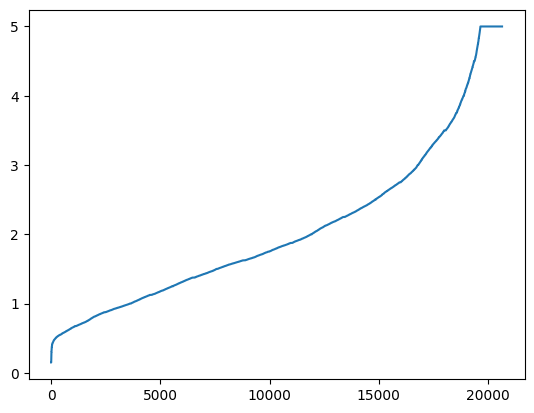

In [ ]:
plt.plot(np.sort(y))
plt.show()

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.47043e-31): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Error de Entrenamiento (MSE): 2.3351
Error de Prueba (MSE): 2.4257


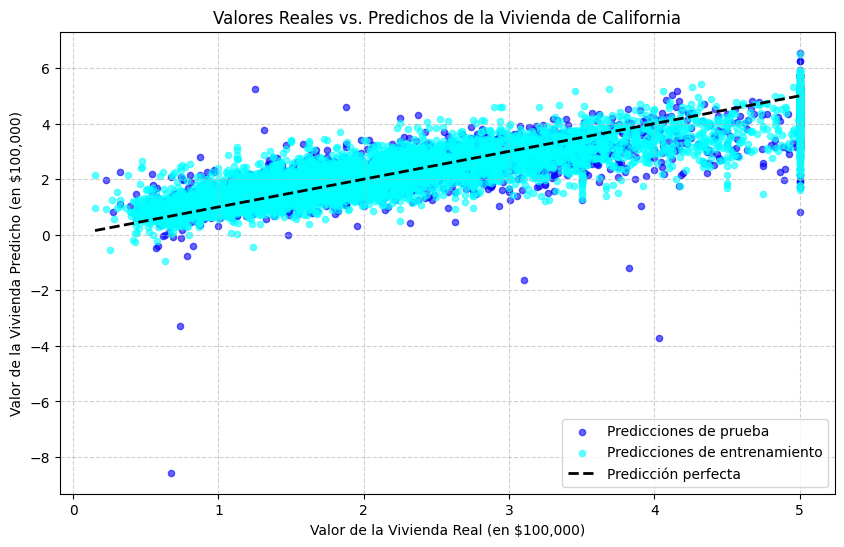

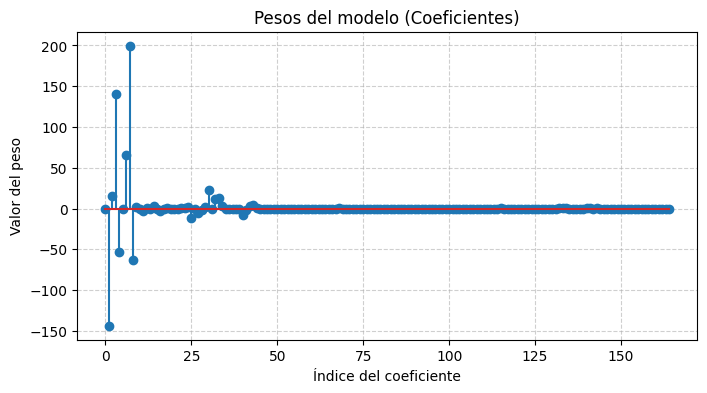

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit

# 1. Cargar el conjunto de datos de California
X, y = fetch_california_housing(return_X_y=True)

# Reducir el tamaño de la muestra para una visualización y cálculo más rápidos
# y para que el ejemplo sea comparable a los datos simulados anteriores
n_samples = 10000
np.random.seed(0)
sample_indices = np.random.choice(len(X), n_samples, replace=False)
X = X[sample_indices]
y = y[sample_indices]

# Se reajusta la forma de y para que sea una columna, como t en el ejemplo anterior
y = y.reshape(-1, 1)

# 2. Generación de la representación polinomial
# Se usa un grado de polinomio más bajo debido a las múltiples características del dataset
Q = 3
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)

# 3. Particionar datos con 70% train y 30% test
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
train_i, test_i = next(rs.split(X))

# 4. Regresor
# La regularización se ajusta para el nuevo dataset
lambdaR = 1e-5
reg_mc = Ridge(alpha=lambdaR)
reg_mc.fit(Phi[train_i], y[train_i])

# 5. Cálculo del error
y_mc_train_pred = reg_mc.predict(Phi[train_i])
y_mc_test_pred = reg_mc.predict(Phi[test_i])

mse_train = np.mean((y[train_i] - y_mc_train_pred)**2)
mse_test = np.mean((y[test_i] - y_mc_test_pred)**2)

print(f'Error de Entrenamiento (MSE): {mse_train:.4f}')
print(f'Error de Prueba (MSE): {mse_test:.4f}')

# 6. Graficar los resultados
# No podemos graficar una curva 2D simple como antes, porque X tiene 8 características.
# En su lugar, graficaremos los valores reales vs. los valores predichos para visualizar el rendimiento.
# Esto es una forma estándar de visualizar el rendimiento de una regresión con múltiples características.

plt.figure(figsize=(10, 6))

# Gráfica de los valores reales vs. los predichos para el conjunto de prueba
plt.scatter(y[test_i], y_mc_test_pred, c='b', s=20, alpha=0.6, label='Predicciones de prueba')

# Gráfica de los valores reales vs. los predichos para el conjunto de entrenamiento
plt.scatter(y[train_i], y_mc_train_pred, c='cyan', s=20, alpha=0.6, label='Predicciones de entrenamiento')

# Se traza la línea de referencia (y=x), donde las predicciones perfectas se ubicarían
max_val = np.max(y)
min_val = np.min(y)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Predicción perfecta')

plt.title('Valores Reales vs. Predichos de la Vivienda de California')
plt.xlabel('Valor de la Vivienda Real (en $100,000)')
plt.ylabel('Valor de la Vivienda Predicho (en $100,000)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Graficar los pesos del modelo
plt.figure(figsize=(8, 4))
plt.stem(reg_mc.coef_.flatten())
plt.title('Pesos del modelo (Coeficientes)')
plt.xlabel('Índice del coeficiente')
plt.ylabel('Valor del peso')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()